Import Libraries

In [1]:
import geopandas as gp
import ast
import pandas as pd
from geopandas import GeoSeries
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import Polygon
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# This function classifies a timeseries' disturbance date, 
# based on whether or not it is a cleared stand or a thinned stand.
# It translates the disturbance map raster code into an integer value 
# for year of disturbance.
def StandAge(pixVal):

    if 14 <= pixVal <= 41:

        return pixVal + 1970

    elif 64 <= pixVal <= 91:

        return pixVal + 1920

    else:
        return -9999

# This function classifies a disturbance map pixel based on whether or 
# not it was cleared completely, or whether it was a thinning disturbance. 
def dMapClasses(pixVal):
    # if it is in the range of forests...
    if 14 <= pixVal <= 91:
        # if it is in the range of clears...
        if 14 <= pixVal <= 41: 
            return "Clear"
        # else if in the range of nonclears...
        elif 64 <= pixVal <= 91:
            return "Thin"
    else:
        return "Other"

In [3]:
# Load in LAI data
lai = pd.read_csv("/Users/wyatt/Downloads/HUC10_LAI_Timeseries_HucCut.csv")

# Load in disturbance codes
dist = pd.read_csv("/Users/wyatt/Downloads/HUC10_Disturbance_Map.csv")

In [4]:
# Merge LAI data and disturbance codes based on common geometry
mrgd = lai.merge(right = dist, \
                               how = "inner", \
                               on = ".geo")

In [5]:
# Create a disturbance class field
mrgd['dist_classes'] = mrgd.mean_y.apply(dMapClasses)

# Create a stand age field
mrgd['dist_year'] = mrgd.mean_y.apply(StandAge)

# Create an acquisition date field
mrgd['date'] = mrgd['imageId'].apply(lambda x: pd.to_datetime(x.split("_")[-1]))

In [6]:
# Remove unknown disturbance dates, or those that fall under "other"
mrgd = mrgd[mrgd.dist_year > 0]

In [7]:
# Add a month field to the data
mrgd["month"] = mrgd.date.apply(lambda x: x.month)

# Add a year field to the data
mrgd["year"] = mrgd.date.apply(lambda x: x.year)

# Ensure only February acquisitions
mrgd = mrgd[mrgd.month == 2]

In [8]:
# Make an age field
mrgd['age'] = mrgd['year'] - mrgd['dist_year']


In [9]:
# Subset dataframe columns
df = mrgd[['date', 'age', 'mean_x', '.geo']]

# Rename LAI column
df['LAI'] = df['mean_x']

# This is the default second disturbance
df["D2"] = pd.to_datetime("2014-01-01")

# Re-arrange the columns
df = df[[".geo", "LAI", "date", "age", "D2"]]

# Re-name the columns
df.columns = ["ID", "LAI", "DATE", "AGE", "D2"]

<ipython-input-9-c179000db1d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAI'] = df['mean_x']
<ipython-input-9-c179000db1d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["D2"] = pd.to_datetime("2014-01-01")


In [10]:
# Dataframe LAI must be between 0 - 10
df = df[df.LAI >= 0]
df = df[df.LAI <= 10]

# Dataframe date must be before the second disturbance date
df = df[df.DATE < df.D2]

# Only LAI at 10 years post-disturbance will be used
df10 = df[df.AGE == 10]

# Take february max for every separate stand
df10 = df10[["ID", "LAI"]].groupby("ID").max()
df10 = df10.reset_index()

In [11]:
len(set(df.ID))

13140

In [12]:
len(df10.ID)

7949

In [13]:
# List polygons and their LAI
polyList = []
pointList = []
laiList = []

# Iterate over the 10th year LAI dataframe
for i in range(len(df10)):
    # Take the row
    row = df10.iloc[i]
    
    # Take all the coordinate lists in the row
    coor = ast.literal_eval(row["ID"])["coordinates"]
    
    # Make polygons for all coordinate lists in the row
    for j in range(len(coor)):
        subCoor = coor[j]
        poly = Polygon([(k[0], k[1]) for k in subCoor])
        
        # Take their leaf area index and the actual polygons
        polyList.append(poly)
        laiList.append(row["LAI"])
        
# Create a geoseries for the polygons
gs = GeoSeries(polyList)
gs.crs = {'init': 'epsg:4326'}

# Take the centroids of the geoseries
ps = gs.centroid


In [14]:
data = {'geometry': ps, 'LAI': laiList}

gdf = pd.DataFrame(data)

gdf = GeoDataFrame(gdf)

In [15]:
pathrows = gp.read_file("/Users/wyatt/Downloads/NovemberMap_latest/Polygons/Pathrows.shp")

In [16]:
va = gp.read_file("/Users/wyatt/Downloads/NovemberMap_latest/Polygons/VA.shp")
va = va.to_crs({"init": "epsg:4326"});

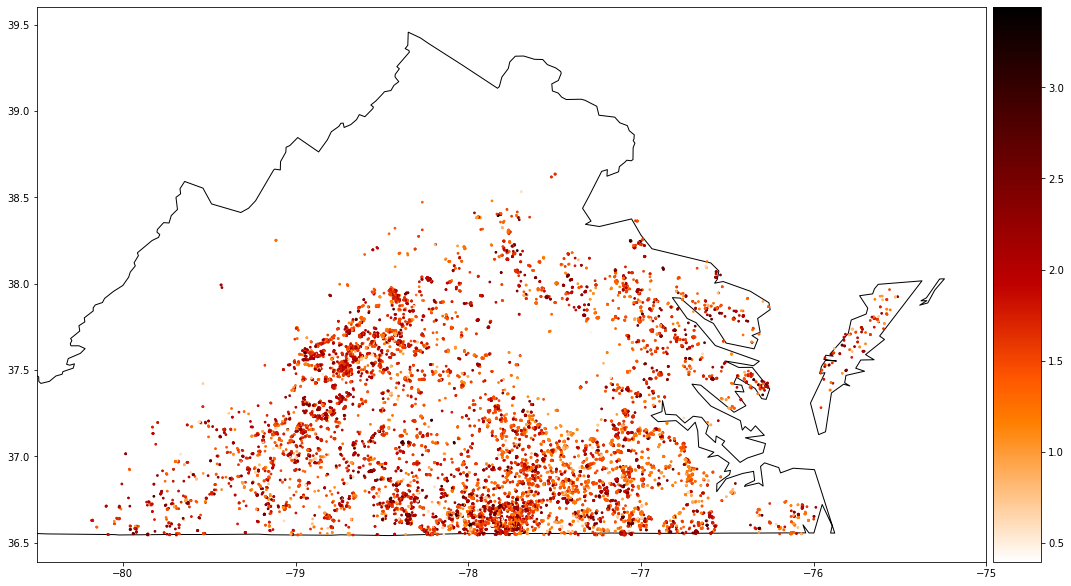

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (18, 18))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

va.plot(ax = ax, cax = cax, edgecolor = "black", facecolor = "none")
# pathrows.plot(ax = ax, cax = cax, edgecolor = "black", facecolor = "none");
gdf.plot(ax = ax, cax = cax, markersize = 3, column = "LAI", cmap = 'gist_heat_r', legend = True);

ax.set_xlim(-80.5, -75);